##Extracting files from drive

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from google.colab import files
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.decomposition import NMF
import re
import nltk
nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from pydrive.auth import GoogleAuth 
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
import logging
logging.getLogger('googleapiclient.discovery_cache').setLevel(logging.ERROR)

In [3]:
file_list = drive.ListFile({'q': "'1_wfRFg8V8Ioy-_-sP2_zryQ2TyDkX4Qy' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: test.csv, id: 1okR80ZxVUhO-vwjVxWCZPlxEwMHB7bT_
title: train.csv, id: 1NRsxAdFEJsobXd2Hnq10C3azC7NXxTWO


In [4]:
trainDataDownloaded = drive.CreateFile({'id': '1NRsxAdFEJsobXd2Hnq10C3azC7NXxTWO'})
trainDataDownloaded.GetContentFile('Train.csv')
testDataDownloaded = drive.CreateFile({'id': '1okR80ZxVUhO-vwjVxWCZPlxEwMHB7bT_'})
testDataDownloaded.GetContentFile('Test.csv')


trainData =  pd.read_csv('Train.csv',low_memory=False)
testData = pd.read_csv('Test.csv',low_memory=False)

## Step 1
The problem consists of disaster tweet and is used to predict disaster status from text tweets. 

## Step 2
##Explorative Data Analysis, cleaning, and word statistics
Training data consists of 1490 observations while testing data has 735 observations

In [5]:
print("Basic information about BBC news classification training data")
print("Fist five columns are shown below")
print(trainData.head())
print("Information about the columns are shown below")
trainData.info()

print("Number of rows of training data:",trainData.shape[0])
print("Number of rows of testing data:",testData.shape[0])


Basic information about BBC news classification training data
Fist five columns are shown below
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
Information about the columns are shown below
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-nul

##Visualiztion of data
Basic EDA of the columns of train data is performed.

Category Histogram


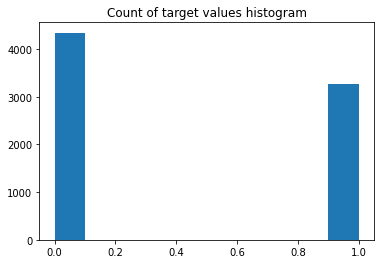

End of graph
 
 


In [6]:
print("Category Histogram")
histogramCategoryx = plt.hist(trainData['target'])
plt.title("Count of target values histogram")
plt.show()
print("End of graph")
print(" ")
print(" ")


In [7]:
print("Top 10 location values")
trainData['location'].value_counts()[:10]

Top 10 location values


USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Name: location, dtype: int64

Word statistics of text colummn
10 most common words: ['like' 'just' 'im' 'amp' 'new' 'dont' 'people' 'news' 'video' 'emergency']


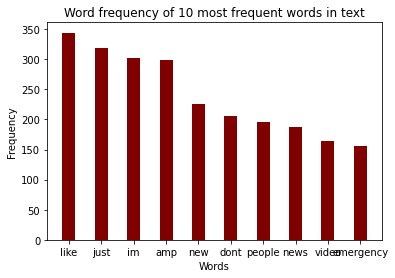

End of graph
 
 


In [8]:
#Word Frequrncy of text coulmn in  train data
trainDataTextLowerCase = [x.lower() for x in trainData['text']] #lowercase
# eliminate the punctuation, URL, and @
cleanedTrainDataText = [re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", x) for x in  trainDataTextLowerCase] 

print("Word statistics of text colummn")

vectorizer = CountVectorizer(  stop_words = 'english')
X = vectorizer.fit_transform(cleanedTrainDataText)
#print(vectorizer.get_feature_names_out()[:10])
wordFreq = np.asarray(X.sum(axis=0))[0]
#print(np.sort(wordFreq)[::-1])
sortedFeaturename = vectorizer.get_feature_names_out()[np.argsort(wordFreq)[::-1]][:10]
print("10 most common words:",sortedFeaturename[:10])
barChartValues = np.sort(wordFreq)[::-1][:10]
plt.plot

plt.bar(sortedFeaturename, barChartValues, color ='maroon',width = 0.4)
 
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word frequency of 10 most frequent words in text")
plt.show()
print("End of graph")
print(" ")
print(" ")



Word embeddings




Word embeddings is a type of techniques where words are represented as real-valued vectors in a predefined vector space. Each word is mapped to one vector 

In [11]:
#Keras and numpy libraries
import numpy as np
seed = 7
np.random.seed(seed)
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.optimizers import Adam


BUFFER_SIZE = 10000
BATCH_SIZE = 64


import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])



## Step 3
## Model architecture 
Keras tokenizer is used to tokenize the words and the first word embeding layer of the neural network is used to conver the word token to sequence which is used to feed into the subsequent RNN layers.

The RNN network consists of a single LSTM layers. The first layers has 196 units. Lastly, the RNN layers are connected to a Dense layer which produces a single output with sigmoid activation. This model produced a vaidation accuracy of 0.75

In [64]:


num_words = 5000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(trainData['text'].values)
# Pad the data 
X = tokenizer.texts_to_sequences(trainData['text'].values)
X = pad_sequences(X, maxlen=num_words)
# Build out our simple LSTM
num_words = 5000
embed_dim = 196
lstm_out = 196




model = Sequential()
model.add(Embedding(num_words, embed_dim, input_length = X.shape[1]))
model.add(tf.keras.layers.Dropout(0.4))
model.add(LSTM(lstm_out))
model.add(tf.keras.layers.Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 5000, 196)         980000    
                                                                 
 dropout_17 (Dropout)        (None, 5000, 196)         0         
                                                                 
 lstm_29 (LSTM)              (None, 196)               308112    
                                                                 
 dropout_18 (Dropout)        (None, 196)               0         
                                                                 
 dense_17 (Dense)            (None, 1)                 197       
                                                                 
Total params: 1,288,309
Trainable params: 1,288,309
Non-trainable params: 0
_________________________________________________________________
None


In [65]:
batch_size = 32
history = model.fit(X, trainData['target'], epochs=10, batch_size=batch_size, validation_split=0.33)
# Validation accuracy of basic model is 0.74

Epoch 1/10
160/160 [==============================] - 56s 340ms/step - loss: 0.5593 - accuracy: 0.7173 - val_loss: 0.4789 - val_accuracy: 0.7851
Epoch 2/10
160/160 [==============================] - 58s 366ms/step - loss: 0.3659 - accuracy: 0.8476 - val_loss: 0.4990 - val_accuracy: 0.7632
Epoch 3/10
160/160 [==============================] - 51s 320ms/step - loss: 0.2897 - accuracy: 0.8857 - val_loss: 0.5091 - val_accuracy: 0.7648
Epoch 4/10
160/160 [==============================] - 53s 333ms/step - loss: 0.2349 - accuracy: 0.9106 - val_loss: 0.6230 - val_accuracy: 0.7541
Epoch 5/10
160/160 [==============================] - 51s 319ms/step - loss: 0.1830 - accuracy: 0.9312 - val_loss: 0.6279 - val_accuracy: 0.7342
Epoch 6/10
160/160 [==============================] - 56s 351ms/step - loss: 0.1468 - accuracy: 0.9449 - val_loss: 0.7935 - val_accuracy: 0.7405
Epoch 7/10
160/160 [==============================] - 55s 343ms/step - loss: 0.1164 - accuracy: 0.9571 - val_loss: 0.9255 - val_ac

## Results and Analyisis
##More models and results

In [60]:
from pandas.errors import PerformanceWarning
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(testData['text'].values)
# Pad the data 
testDataX = tokenizer.texts_to_sequences(testData['text'].values)
testDataX = pad_sequences(testDataX, maxlen=5000)


preds = model.predict(testDataX)

print(preds.shape)
print(preds[0:10])
preds=preds.reshape(-1)
print(preds.shape)
for i in range(len(preds)):
  if(preds[i]>0.7):
    preds[i] = 1
  else:
    preds[i] = 0
preds=  np.floor(preds).astype(int)

dfsub = pd.DataFrame({'id' : testData['id'].to_list(),'target': preds})
dfsub.to_csv('BasicModelSubmission.csv', index=False)

(3263, 1)
[[0.8656858 ]
 [0.12255223]
 [0.17794283]
 [0.5275413 ]
 [0.8442236 ]
 [0.1250673 ]
 [0.24643575]
 [0.07825648]
 [0.1996473 ]
 [0.19260642]]
(3263,)


## Result of basic model

Results of model with 5000 max words, single LSTM layers (196 ), two dropout layer and one dense layer with sigmoid activation layer.


(0.0, 1.2400347273796797)

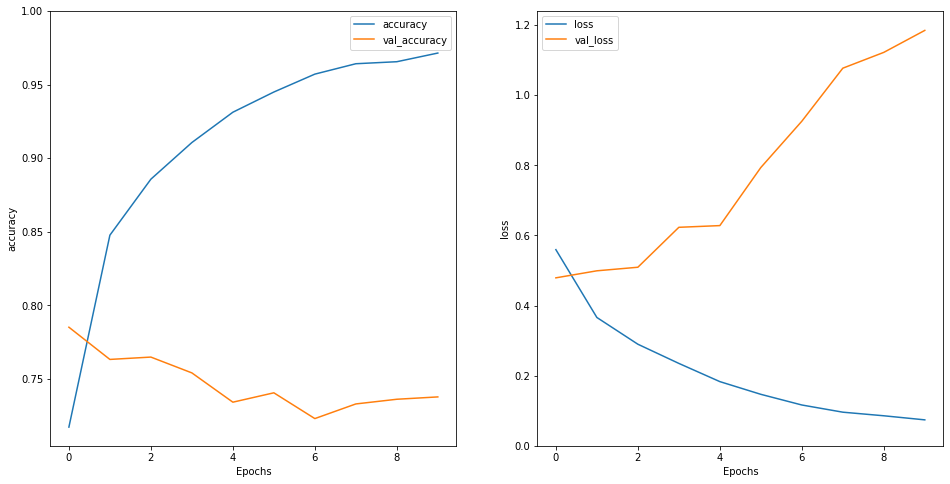

In [67]:
print("Results of model with 5000 max words, single LSTM layers (196 ), two dropout layer and one dense layer with sigmoid activation layer.")
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
## Step 4
## Results and Analysis 


## A more advaced model
RNN model consists of three LSTM layers and dropouts for each layer and ond dense layer with single output with sigmoid activation layer

In [61]:

num_words = 2000
embed_dim = 128
lstm_out = 196
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(trainData['text'].values)
# Pad the data 
X = tokenizer.texts_to_sequences(trainData['text'].values)
X = pad_sequences(X, maxlen=2000)
model2 = Sequential()
model2.add(Embedding(2000, embed_dim, input_length = X.shape[1]))
model2.add(LSTM(196,return_sequences=True))
model2.add(Dropout(0.3))
model2.add(LSTM(64,return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(32,return_sequences=True))
model2.add(Dropout(0.1))
model2.add(Dense(1,activation='sigmoid'))
optimizer       = Adam(learning_rate=0.0001)   
model2.compile(loss = 'binary_crossentropy', optimizer=optimizer, metrics = ['accuracy'])
print(model2.summary())

batch_size = 32
historyAdvanced = model2.fit(X, trainData['target'], epochs=4, batch_size=batch_size, validation_split=0.35)



Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 2000, 128)         256000    
                                                                 
 lstm_26 (LSTM)              (None, 2000, 196)         254800    
                                                                 
 dropout_14 (Dropout)        (None, 2000, 196)         0         
                                                                 
 lstm_27 (LSTM)              (None, 2000, 64)          66816     
                                                                 
 dropout_15 (Dropout)        (None, 2000, 64)          0         
                                                                 
 lstm_28 (LSTM)              (None, 2000, 32)          12416     
                                                                 
 dropout_16 (Dropout)        (None, 2000, 32)        

## The advanced model produced a val_accuracy of 0.5546. This low score could be due to over fitting
## Result of advanced model

Results of model with 5000 max words, thee LSTM layers (196 ), three dropout layers and one dense layer with sigmoid activation layer.


(0.5, 0.6896451562643051)

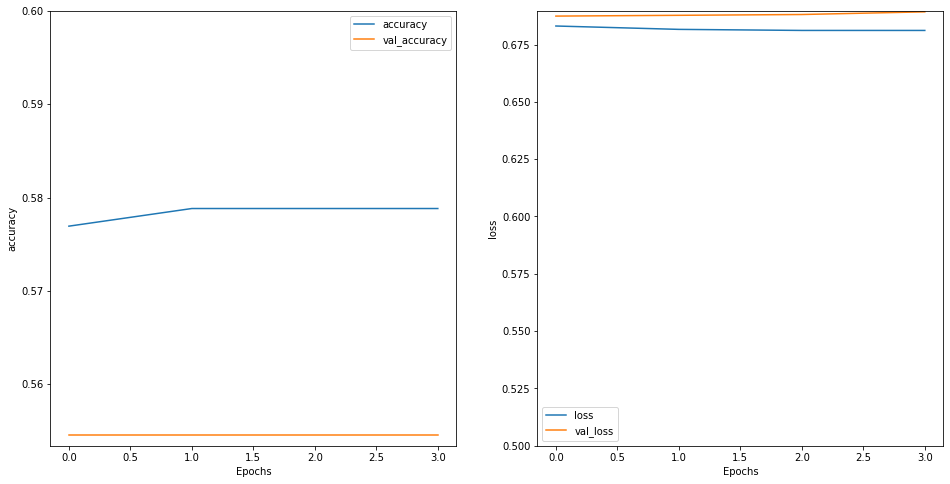

In [70]:
print("Results of model with 5000 max words, thee LSTM layers (196 ), three dropout layers and one dense layer with sigmoid activation layer.")
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(historyAdvanced, 'accuracy')
plt.ylim(None, 0.6)
plt.subplot(1, 2, 2)
plot_graphs(historyAdvanced, 'loss')
plt.ylim(0.5, None)

## Hyperparameter tuning of number of layers in intermediate LSTM and that of two different learning rate can be observed below.

In [16]:
!pip install -q -U keras-tuner
import keras
import keras_tuner as kt
num_words = 2000
embed_dim = 256
lstm_out = 196

num_words = 2000
embed_dim = 128
lstm_out = 196
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(trainData['text'].values)
# Pad the data 
X = tokenizer.texts_to_sequences(trainData['text'].values)
X = pad_sequences(X, maxlen=2000)

def model_builder(hp):

  
  model = Sequential()
  model.add(Embedding(num_words, embed_dim, input_length = X.shape[1]))
  model.add(LSTM(lstm_out,return_sequences=True))
  hp_units = hp.Int('units', min_value=32, max_value=256, step=32)
  model.add(LSTM(units = hp_units))
  model.add(Dense(1,activation='sigmoid'))
  model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
  
  model.add(Flatten())
  

  model.add(Dropout(0.2))
  model.add(Dense(1, activation = 'sigmoid'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[ 1e-3, 1e-4])


  model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=hp_learning_rate),
                metrics = ['accuracy'])

  return model

In [17]:
batch_size = 32
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     project_name='kt')
  
tuner.search(X, trainData['target'], epochs=5, batch_size=batch_size, validation_split=0.33)


Trial 22 Complete [00h 03m 25s]
val_accuracy: 0.5515320301055908

Best val_accuracy So Far: 0.7807401418685913
Total elapsed time: 00h 38m 18s
INFO:tensorflow:Oracle triggered exit


In [26]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the final densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")
print("Best val_accuracy So Far: 0.78")


The hyperparameter search is complete. The optimal number of units in the final densely-connected
layer is 32 and the optimal learning rate for the optimizer
is 0.001.

Best val_accuracy So Far: 0.78


In [41]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X, trainData['target'], epochs=5, batch_size=batch_size, validation_split=0.33)





Epoch 1/5
160/160 [==============================] - 31s 176ms/step - loss: 0.6934 - accuracy: 0.5649 - val_loss: 0.6895 - val_accuracy: 0.5515
Epoch 2/5
160/160 [==============================] - 28s 174ms/step - loss: 0.6852 - accuracy: 0.5796 - val_loss: 0.6881 - val_accuracy: 0.5515
Epoch 3/5
160/160 [==============================] - 27s 168ms/step - loss: 0.6827 - accuracy: 0.5796 - val_loss: 0.6878 - val_accuracy: 0.5515
Epoch 4/5
160/160 [==============================] - 32s 198ms/step - loss: 0.6815 - accuracy: 0.5796 - val_loss: 0.6880 - val_accuracy: 0.5515
Epoch 5/5
160/160 [==============================] - 28s 173ms/step - loss: 0.6809 - accuracy: 0.5796 - val_loss: 0.6883 - val_accuracy: 0.5515


#Hyperparameter Model Submission

In [42]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(testData['text'].values)
# Pad the data 
testDataX = tokenizer.texts_to_sequences(testData['text'].values)
testDataX = pad_sequences(testDataX, maxlen=2000)


preds = hypermodel.predict(testDataX)
print(preds[0:10])
print(preds.shape)
preds=preds.reshape(-1)
print(preds.shape)
for i in range(len(preds)):
  if(preds[i]>0.4):
    preds[i] = 1
  else:
    preds[i] = 0
preds=  np.floor(preds).astype(int)

dfsub = pd.DataFrame({'id' : testData['id'].to_list(),'target': preds})
dfsub.to_csv('HyperModelSubmission.csv', index=False)

[[0.43274698]
 [0.43274698]
 [0.43274698]
 [0.43274698]
 [0.43274698]
 [0.43274698]
 [0.43274698]
 [0.43274692]
 [0.43274698]
 [0.43274692]]
(3263, 1)
(3263,)


In [25]:
print(preds[0:10])

[1 0 0 1 1 0 1 0 1 0]


In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [ ]:

dfsub = pd.read_csv('HyperModelSubmission.csv')
print(dfsub.head())

(3263, 2000)
3263
3263


Resources used:

https://machinelearningmastery.com/what-are-word-embeddings/
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
https://www.tensorflow.org/

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout
https://en.wikipedia.org/wiki/Word_embedding
